In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Low Volume NAICS performance
Look at the model performance vs. # of businesses per NAICS.  Examine NAICS codes present in the training and test data only.  Bucket NAICS by volume, and look at test dataset performance for businesses corresponding to the buckets. 

Also combine all metrics for easy comparisons

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from pathlib import Path

In [4]:
from sba_gnn.sba_gnn import sg_plot 

In [5]:
sg_plot.plot_defaults()

## File Dictionaries

##### Raw predictions - will get metrics for low volume naics

In [6]:
dict_pred = {'xgb base': Path(setup.temp_path).joinpath('03_DATA_combined_predictions.parquet'),
              'xgb mean':  Path(setup.temp_path).joinpath('04_DATA_combined_predictions.parquet'),
              'xgb one hot':  Path(setup.temp_path).joinpath('05_DATA_combined_predictions.parquet'),
              'xgb numeric naics':  Path(setup.temp_path).joinpath('06_DATA_combined_predictions.parquet'),
              'xgb mean x naics sector':  Path(setup.temp_path).joinpath('07_DATA_combined_predictions.parquet'),
              'xgb mean x naics4':  Path(setup.temp_path).joinpath('08_DATA_combined_predictions.parquet'),
              'xgb mean x naics3':  Path(setup.temp_path).joinpath('09_DATA_combined_predictions.parquet'),
              'xgb one hot - clus nn emb':  Path(setup.temp_path).joinpath('61_DATA_combined_predictions.parquet'),
              'xgb mean x clus nn emb':  Path(setup.temp_path).joinpath('62_DATA_combined_predictions.parquet'),
              'nn base': Path(setup.temp_path).joinpath('11_DATA_predictions.parquet'),
               'nn emb': Path(setup.temp_path).joinpath('12_DATA_predictions.parquet'),
             'nn emb x naics sector': Path(setup.temp_path).joinpath('16_DATA_predictions.parquet'),
            }

In [7]:
# Verify these all exist
all([Path(v).exists() for k, v in dict_pred.items()])

True

In [8]:
#{k:Path(v).exists() for k, v in dict_pred.items()}

##### Standard metrics
Get filenames for standard metrics calculated in all scripts. These all have similar file naming

In [9]:
dict_metrics = {k:Path(setup.temp_path).joinpath(v.name[0:2] + '_REPORT_metrics.csv') \
                for k, v in dict_pred.items()}

In [10]:
# Verify these all exist
all([Path(v).exists() for k, v in dict_metrics.items()])

True

## Combine standard metrics

In [11]:
all_metrics = pd.concat([pd.read_csv(v) for k, v in dict_metrics.items()],
                        keys = dict_metrics.keys()) \
    .reset_index(level=0) \
    .drop(columns=['Unnamed: 0'], errors='ignore') \
    .rename(columns={'level_0':'model'})

In [12]:
all_metrics[(all_metrics['dset'] == 'test') & (all_metrics['dset_naics_holdout'] == 0)] \
    .sort_values('average_precision_score', ascending=False)

,model,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
3,xgb mean x naics3,test,0.666502,0.451238,0.339382,0.673077,0.390645,0.733338,0.0
3,xgb mean x naics4,test,0.666754,0.449633,0.338804,0.668222,0.390023,0.732462,0.0
3,xgb mean,test,0.637072,0.449935,0.325452,0.728627,0.389849,0.732194,0.0
3,xgb mean x naics sector,test,0.638895,0.450566,0.326477,0.726818,0.389739,0.732311,0.0
3,xgb mean x clus nn emb,test,0.665348,0.450260,0.338361,0.672744,0.389213,0.732048,0.0
3,nn emb,test,0.660141,0.450865,0.336043,0.684882,0.388653,0.732290,0.0
3,nn embx naics sector,test,0.676984,0.450776,0.344828,0.650704,0.388243,0.731821,0.0
3,xgb one hot - clus nn emb,test,0.654390,0.449398,0.332662,0.692355,0.381205,0.728506,0.0
3,xgb numeric naics,test,0.653857,0.444074,0.330008,0.678646,0.378392,0.725089,0.0
3,xgb one hot,test,0.618162,0.438666,0.313099,0.732388,0.360212,0.714582,0.0


In [13]:
all_metrics[(all_metrics['dset'] == 'test') & (all_metrics['dset_naics_holdout'] == 1)] \
    .sort_values('f1_score', ascending=False)

,model,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
4,xgb numeric naics,test,0.678191,0.429051,0.324135,0.634388,0.362891,0.729245,1.0
4,xgb one hot,test,0.633594,0.425756,0.303555,0.712644,0.353897,0.722105,1.0
4,nn base,test,0.614267,0.425718,0.297193,0.750118,0.348599,0.718693,1.0
4,xgb base,test,0.626182,0.424931,0.300607,0.724610,0.355814,0.723045,1.0
4,xgb mean,test,0.619579,0.424237,0.298117,0.735317,0.352738,0.721075,1.0
4,xgb mean x clus nn emb,test,0.577654,0.421792,0.285357,0.808219,0.352236,0.719787,1.0
4,xgb mean x naics sector,test,0.630263,0.420017,0.299577,0.702409,0.338828,0.712509,1.0
4,xgb mean x naics4,test,0.695357,0.419578,0.329413,0.577704,0.356358,0.724233,1.0
4,xgb mean x naics3,test,0.669038,0.411777,0.311366,0.607778,0.337917,0.713045,1.0
4,xgb one hot - clus nn emb,test,0.530326,0.409879,0.269473,0.855771,0.345317,0.716564,1.0


In [14]:
all_metrics.to_csv(Path(setup.temp_path).joinpath('60_REPORT_metrics_combined.csv'), index=False)

## Examine Low Volume, Non-Holdout NAICS
Do the poorer results for "holdout" NAICS also occur for infrequent NAICS?

##### Import loans data to label NAICS as low volume

In [15]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [16]:
train_df = sba_loans[sba_loans['dset'] == 'train']
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

#### NAICS volume and selection
Find NAICS in the training data and get # of associated businesses.  

In [17]:
naics_train_info = sba_loans[sba_loans['dset'] == 'train'][['NAICS']].value_counts().reset_index()

In [18]:
naics_train_info['count'].sum()

425594

In [19]:
naics_train_info['naics_count_grp'] = pd.cut(naics_train_info['count'], [1, 50, 500, np.Inf],
                                           include_lowest=True)

In [20]:
naics_train_info.groupby('naics_count_grp')['count'].agg(['min', 'max', 'mean', 'count', 'sum'])

,min,max,mean,count,sum
naics_count_grp,,,,,
"(0.999, 50.0]",1,50,18.422594,478,8806
"(50.0, 500.0]",51,486,174.461672,574,100141
"(500.0, inf]",501,18218,1759.150000,180,316647


##### Codes also in test

In [21]:
naics_train_info = naics_train_info.merge(sba_loans[sba_loans['dset'] == 'test'][['NAICS']].drop_duplicates(),
                                          on='NAICS')

In [22]:
naics_train_info.groupby('naics_count_grp')['count'].agg(['min', 'max', 'mean', 'count', 'sum'])

,min,max,mean,count,sum
naics_count_grp,,,,,
"(0.999, 50.0]",1,50,21.299252,401,8541
"(50.0, 500.0]",51,486,174.461672,574,100141
"(500.0, inf]",501,18218,1759.150000,180,316647


In [23]:
naics_train_info

,NAICS,count,naics_count_grp
0,722110,18218,"(500.0, inf]"
1,722211,12712,"(500.0, inf]"
2,811111,9264,"(500.0, inf]"
3,621210,8997,"(500.0, inf]"
4,624410,6432,"(500.0, inf]"
...,...,...,...
1150,926120,1,"(0.999, 50.0]"
1151,922150,1,"(0.999, 50.0]"
1152,315992,1,"(0.999, 50.0]"
1153,212399,1,"(0.999, 50.0]"


In [24]:
naics_train_info.to_csv(Path(setup.temp_path).joinpath('60_REPORT_naics_train_counts.csv'), index=False)

### Metrics By NAICS Volume

##### Function to take in a predictions file and get all metrics

In [25]:
def pred_metrics(filename, 
                 naics_map = sba_loans[['NAICS', 'LoanNr_ChkDgt']],
                naics_counts = naics_train_info[['NAICS', 'naics_count_grp']]):
    """ Open file, merge NAICS counts, and get metrics by NAICS count"""
    pred_df = pd.read_parquet(filename) \
        [['LoanNr_ChkDgt', 'predict_prob', 'predict_bin', 'target', 'dset']]
    
    pred_sel = pred_df[pred_df['dset'] == 'test'] \
        .merge(naics_map[['NAICS', 'LoanNr_ChkDgt']], on='LoanNr_ChkDgt') \
        .merge(naics_counts[['NAICS', 'naics_count_grp']], on='NAICS')

    return pred_sel.groupby('naics_count_grp') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()

##### Apply function to many models
Summarize by count group

In [26]:
metrics_naics_vol = pd.concat([pred_metrics(v) for k, v in dict_pred.items()],
                         keys = dict_pred.keys()) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'model'})

In [27]:
metrics_naics_vol['dset'] = 'test'

In [28]:
metrics_naics_vol.to_csv(Path(setup.temp_path).joinpath('60_REPORT_metrics_by_naics_volume.csv'),
                    index=False)

In [29]:
metrics_naics_vol[metrics_naics_vol['naics_count_grp'].astype('str') == '(0.999, 50.0]'] \
    .sort_values('f1_score', ascending=False).head(5)

,model,naics_count_grp,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset
0,xgb numeric naics,"(0.999, 50.0]",0.739852,0.470693,0.367036,0.655941,0.385771,0.770224,test
0,xgb one hot,"(0.999, 50.0]",0.707115,0.451349,0.336996,0.683168,0.365987,0.757162,test
0,xgb mean x naics sector,"(0.999, 50.0]",0.754256,0.450732,0.371981,0.571782,0.391756,0.756666,test
0,xgb mean x naics4,"(0.999, 50.0]",0.772588,0.448677,0.391867,0.524752,0.390010,0.756665,test
0,nn base,"(0.999, 50.0]",0.678743,0.447447,0.321121,0.737624,0.365050,0.754408,test


## Summary Data
For test dataset only, show AUC and f1 scores for test dataset, along with f1 scores for holdout and low-volume NAICS

In [30]:
overall_stats =  all_metrics[(all_metrics['dset'] == 'test') & \
                             (all_metrics['dset_naics_holdout'] == 0)] \
    [['model', 'roc_auc_score', 'average_precision_score', 'f1_score']]

In [31]:
holdout_stats = all_metrics[(all_metrics['dset'] == 'test') & \
                            (all_metrics['dset_naics_holdout'] == 1)] \
    [['model', 'f1_score']] \
    .rename(columns={'f1_score':'f1_score_ho'})

In [32]:
low_vol_stats = metrics_naics_vol[metrics_naics_vol['naics_count_grp'].astype('str') == '(0.999, 50.0]'] \
     [['model', 'f1_score']] \
    .rename(columns={'f1_score':'f1_score_low_vol'})   

In [33]:
overall_stats = overall_stats.merge(holdout_stats, on='model') \
    .merge(low_vol_stats, on='model')

##### Type information

In [34]:
cond = [overall_stats['model'].str.startswith('xgb emb'),
        overall_stats['model'].str.startswith('xgb dgi'),
        overall_stats['model'].str.startswith('xgb'),
       overall_stats['model'].str.startswith('gnn')]
choice = ['xgb emb nn', 'xgb dgi', 'xgb', 'gnn']
overall_stats['type'] = np.select(cond, choice, 'nn')   

In [35]:
overall_stats['model_base'] = overall_stats['model'].str.split('+count', regex=False).apply(lambda x: x[0])
overall_stats['count_enc'] = np.where(overall_stats['model'].str.contains('+count', regex=False), 1, 0)

In [36]:
overall_stats.sort_values('f1_score_low_vol', ascending=False)

,model,roc_auc_score,average_precision_score,f1_score,f1_score_ho,f1_score_low_vol,type,model_base,count_enc
3,xgb numeric naics,0.725089,0.378392,0.444074,0.429051,0.470693,xgb,xgb numeric naics,0
2,xgb one hot,0.714582,0.360212,0.438666,0.425756,0.451349,xgb,xgb one hot,0
4,xgb mean x naics sector,0.732311,0.389739,0.450566,0.420017,0.450732,xgb,xgb mean x naics sector,0
5,xgb mean x naics4,0.732462,0.390023,0.449633,0.419578,0.448677,xgb,xgb mean x naics4,0
9,nn base,0.702495,0.345526,0.430669,0.425718,0.447447,nn,nn base,0
0,xgb base,0.706044,0.352200,0.431370,0.424931,0.446166,xgb,xgb base,0
8,xgb mean x clus nn emb,0.732048,0.389213,0.450260,0.421792,0.445607,xgb,xgb mean x clus nn emb,0
6,xgb mean x naics3,0.733338,0.390645,0.451238,0.411777,0.445369,xgb,xgb mean x naics3,0
1,xgb mean,0.732194,0.389849,0.449935,0.424237,0.445092,xgb,xgb mean,0
10,nn emb,0.732290,0.388653,0.450865,0.406653,0.433161,nn,nn emb,0


In [37]:
overall_stats.to_csv(Path(setup.temp_path).joinpath('60_REPORT_summary_stats.csv'),
                    index=False)

<Axes: xlabel='roc_auc_score', ylabel='average_precision_score'>

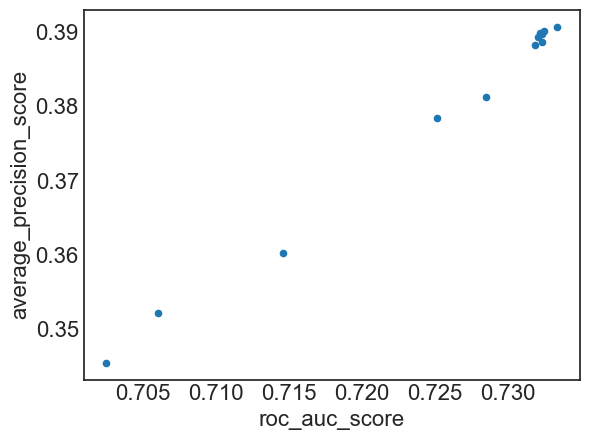

In [38]:
overall_stats.plot(x='roc_auc_score', y='average_precision_score',  kind='scatter')

<Axes: xlabel='f1_score_low_vol', ylabel='f1_score_ho'>

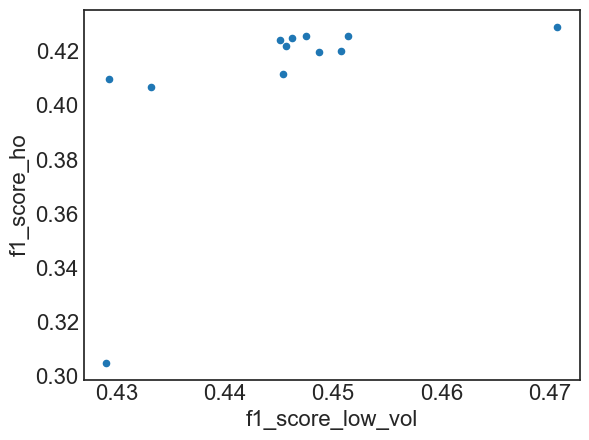

In [39]:
overall_stats.plot(x='f1_score_low_vol', y='f1_score_ho',  kind='scatter')
#plt.gca().axline((0.4, 0.4), slope=1)

<Axes: xlabel='f1_score', ylabel='f1_score_low_vol'>

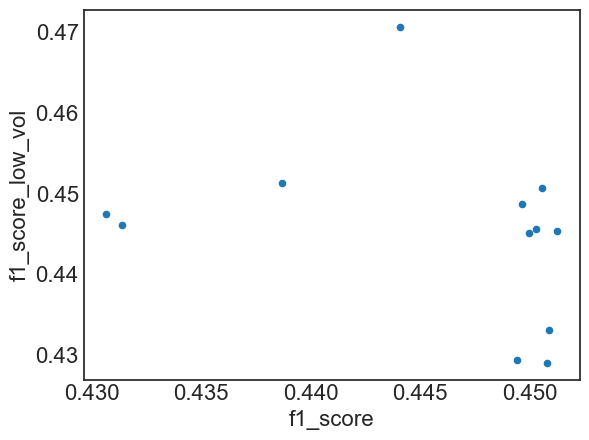

In [40]:
overall_stats.plot(x='f1_score', y='f1_score_low_vol',  kind='scatter')
#plt.gca().axline((0.41, 0.41), slope=1)

<Axes: xlabel='f1_score', ylabel='f1_score_ho'>

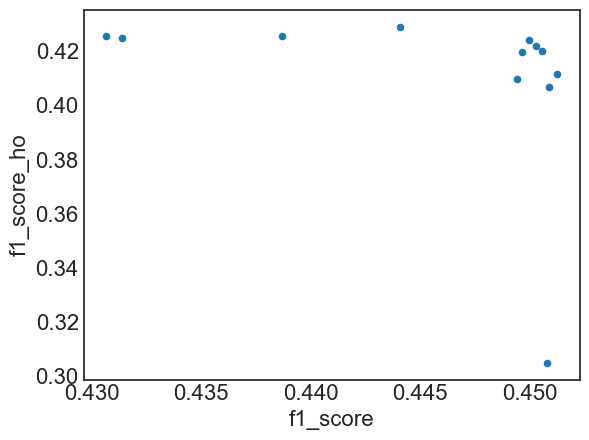

In [41]:
overall_stats.plot(x='f1_score', y='f1_score_ho',  kind='scatter')
#plt.gca().axline((0.4, 0.4), slope=1)

## Color Code f1
Or otherwise show info

## Plot selected metrics

In [42]:
overall_perf = 0.44

In [43]:
sg_plot.plot_defaults()
#plt.style.use('fast')

In [44]:
#model_list = ['xgb baseline', 'nn baseline', 'nn embed NAICS', 'gnn']
#model_list = ['xgb baseline', 'xgb mean encoding', 'xgb numeric NAICS', 'nn baseline', 'nn embed NAICS',
#             'xgb + nn embed', 'xgb + dgi embed', 'xgb + dgi embed, label']
model_list = dict_pred.keys()

In [45]:
metric = 'f1_score'

In [46]:
#[metrics_comb['model'].isin(model_list)] \
metrics_comb['model'] = pd.Categorical(metrics_comb['model'], categories = model_list)
plot_df = metrics_comb \
    [['count_grp', metric, 'model']] \
    .pivot(index='count_grp', columns='model', values=metric)

NameError: name 'metrics_comb' is not defined

In [ ]:
plot_df['xgb baseline']

In [ ]:
ax = sns.heatmap(plot_df.transpose(), linewidth=0.5, cmap="PuOr")
plt.show()
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_perf_by_naics_count.png'),
                  bbox_inches='tight')

In [ ]:
TO DO
Run 03 to get idea of variability in scores
Rerun 6X
Check runs 17, 18
Run NN models for embedding groups
Fix 80 titles / markdown
Count encodings - later subfolder
consider looking at preformance after repitiion